In [1]:
from mesmer import Mesmer


In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from tqdm import tqdm



In [3]:
from mesmer import mesmer_preprocess
from iter_semantic import SemanticDataGenerator
from iter_cropping import CroppingDataGenerator

In [4]:
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
# # Only use if saved data gets deleted
# tissuenet = TissueNet(version='1.1')
# X_train, y_train, meta_train = tissuenet.load_data(split='train')
# X_val, y_val, meta_val = tissuenet.load_data(split='val')
# X_test, y_test, meta_test = tissuenet.load_data(split='test')

In [6]:
tissuenet_dir = "/data/tissuenet"
if not os.path.exists(tissuenet_dir):
    print("Created tissuenet data dir")
    os.makedirs(tissuenet_dir)

print(os.listdir(tissuenet_dir))

['train.npz', 'val_256x256.npz', 'test_256x256.npz', 'train_limited.npz', 'train_512.npz']


In [7]:
from file_utils import _load_npz, load_data

In [8]:
from evaluate_utils import evaluate

In [9]:
from model_utils import create_model

In [10]:
# instantiate model
crop_size = 256
backbone = 'resnet50'
lr = 0.0001
model, losses, optimizer = create_model(
    input_shape=(crop_size, crop_size, 2),
    backbone=backbone,
    lr=lr,
    device=device,
)

cuda:0


In [11]:
def create_data_generators(
    train_dict,
    val_dict,
    rotation_range=180,
    shear_range=0,
    zoom_min=0.7,
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256),
    seed=0,
    batch_size=8,
    min_objects=0,
):
    # use augmentation for training but not validation
    datagen = CroppingDataGenerator(
        rotation_range=rotation_range,
        shear_range=shear_range,
        zoom_range=(zoom_min, 1 / zoom_min),
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        crop_size=(crop_size, crop_size),
    )

    datagen_val = SemanticDataGenerator(
        rotation_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=0,
        vertical_flip=0,
    )

    train_data = datagen.flow(
        train_dict,
        seed=seed,
        transforms=["inner-distance", "pixelwise"],
        transforms_kwargs={
            "pixelwise": {"dilation_radius": 1},
            "inner-distance": {"erosion_width": 1, "alpha": "auto"},
        },
        min_objects=0,
        batch_size=batch_size,
    )

    val_data = datagen_val.flow(
        val_dict,
        seed=seed,
        transforms=["inner-distance", "pixelwise"],
        transforms_kwargs={
            "pixelwise": {"dilation_radius": 1},
            "inner-distance": {"erosion_width": 1, "alpha": "auto"},
        },
        min_objects=min_objects,
        batch_size=batch_size,
    )

    return train_data, val_data


In [12]:
seed = 0
zoom_min = 0.75
batch_size = 8

In [13]:
(X_train, y_train), (X_val, y_val) = load_data(tissuenet_dir)
X_test, y_test = _load_npz(os.path.join(tissuenet_dir, "test_256x256.npz"))

Loaded train.npz: X.shape: (2580, 512, 512, 2), y.shape (2580, 512, 512, 2)
Loaded val_256x256.npz: X.shape: (3118, 256, 256, 2), y.shape (3118, 256, 256, 2)
Loaded test_256x256.npz: X.shape: (1324, 256, 256, 2), y.shape (1324, 256, 256, 2)


In [16]:
smaller = 20
smaller_test = None
if smaller:
    X_train, y_train = X_train[:smaller], y_train[:smaller]
    X_val, y_val = X_val[:smaller], y_val[:smaller]
if smaller_test:
    X_test, y_test = X_test[:smaller_test], y_test[:smaller_test]

In [17]:
train_dict = {"X": mesmer_preprocess(X_train), "y": y_train}
val_dict = {"X": mesmer_preprocess(X_val), "y": y_val}

In [18]:
print(train_dict["X"].shape)

(20, 512, 512, 2)


In [19]:
train_data, val_data = create_data_generators(
    train_dict,
    val_dict,
    seed=seed,
    zoom_min=zoom_min,
    batch_size=batch_size,
    crop_size=crop_size,
)

In [20]:
def train_one_epoch(model):
    running_loss_avg = 0.
    count = 0

    per_epoch_steps = len(X_train)//batch_size if len(X_train)%batch_size==0 else (len(X_train)//batch_size + 1)
    for _ in tqdm(range(per_epoch_steps)):
        count += 1
        
        li_inputs, li_labels = train_data.next()
        
        inputs = np.transpose(li_inputs, (0, 3, 1, 2))
        labels = [np.transpose(l, (0, 3, 1, 2)) for l in li_labels]

        optimizer.zero_grad()
        
        outputs = model(inputs)

        loss = sum([losses[j](outputs[j], labels[j]) for j in range(len(losses))])
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.001, error_if_nonfinite=True)
    
        optimizer.step()

        running_loss_avg += loss.item()
        
    return running_loss_avg/count

In [21]:
loss_tracking = []
vloss_tracking = []
decay_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.33, patience=5,)

In [22]:
start = time.time()
end = time.time()

epoch_number = 0
start_epoch = 0
EPOCHS = 10

best_vloss = 1_000_000.

model = model.to(device)

save_path_prefix = "/data/saved_model"
if smaller is None:
    save_path_prefix = save_path_prefix + "_full_gen_" + str(batch_size)
else:
    save_path_prefix = save_path_prefix + "_" + str(smaller)

for epoch in range(start_epoch, EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    print("TRAIN")
    model.train(True)
    avg_loss = train_one_epoch(model)
    count = 0
    
    running_vloss_avg = 0.
    
    print("VAL")
    model.eval()

    per_epoch_steps = len(X_val)//batch_size if len(X_val)%batch_size==0 else (len(X_val)//batch_size + 1)
    with torch.no_grad():
        for _ in tqdm(range(per_epoch_steps)):
            count += 1
            
            li_inputs, li_labels = val_data.next()

            vinputs = np.transpose(li_inputs, (0, 3, 1, 2))
            vlabels = [np.transpose(l, (0, 3, 1, 2)) for l in li_labels]
            
            voutputs = model(vinputs)
            
            vloss = sum([losses[j](voutputs[j], vlabels[j]) for j in range(len(losses))])
                
            running_vloss_avg += vloss
                
    avg_vloss = running_vloss_avg/count

    decay_scheduler.step()
    plateau_scheduler.step(avg_vloss)
    print(decay_scheduler.get_last_lr())
    
    loss_tracking.append(avg_loss)
    vloss_tracking.append(avg_vloss)
    
    # Save model periodically
    if (epoch+1)%10==0:
        epoch_path_prefix = save_path_prefix + "_epoch" + str(epoch+1)
        dict_save_path = epoch_path_prefix + "_dict.pth"
        save_path = epoch_path_prefix + ".pth"
        
        torch.save(model.state_dict(), dict_save_path)
        # torch.save(model, save_path)
    
    if avg_vloss<best_vloss:
        best_vloss = avg_vloss
        dict_save_path = save_path_prefix + "_dict.pth"
        save_path = save_path_prefix + ".pth"
        
        torch.save(model.state_dict(), dict_save_path)
        # torch.save(model, save_path)
        
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    epoch_number += 1


print("Avg epoch time", (end - start)/EPOCHS)
print("Best validation loss -", best_vloss)

EPOCH 1:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.97s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


[9.900000000000001e-05]
LOSS train 0.1742622951666514 valid 0.13316649198532104
EPOCH 2:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]


[9.801e-05]
LOSS train 0.11694307873646419 valid 0.13130447268486023
EPOCH 3:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.36s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


[9.70299e-05]
LOSS train 0.10441154738267262 valid 0.12129414081573486
EPOCH 4:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.18s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s]


[9.605960100000001e-05]
LOSS train 0.09101710220177968 valid 0.1208849549293518
EPOCH 5:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


[9.509900499000001e-05]
LOSS train 0.08936301867167155 valid 0.11435913294553757
EPOCH 6:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.22s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


[9.414801494010001e-05]
LOSS train 0.0764459843436877 valid 0.10548636317253113
EPOCH 7:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.24s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


[9.320653479069902e-05]
LOSS train 0.07636506358782451 valid 0.09996917098760605
EPOCH 8:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.32s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


[9.227446944279203e-05]
LOSS train 0.07003127535184224 valid 0.09241850674152374
EPOCH 9:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


[9.13517247483641e-05]
LOSS train 0.08065596347053845 valid 0.10203294456005096
EPOCH 10:
TRAIN


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.25s/it]


VAL


100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]


[9.043820750088047e-05]
LOSS train 0.07133778929710388 valid 0.09086208790540695
Avg epoch time 5.364418029785156e-06
Best validation loss - tensor(0.0909, device='cuda:0')


In [32]:
# model, _, _ = create_model(
#     input_shape=(crop_size, crop_size, 2),
#     backbone=backbone,
#     lr=lr,
# )
model.load_state_dict(torch.load(dict_save_path, map_location=device, weights_only=True))

# model = torch.load("/data/saved_model_full_gen_8.pth", weights_only=False)

<All keys matched successfully>

In [33]:
# cpu_device = torch.device("cuda:0")
cpu_device = device
cpu_model = model.to(cpu_device)
cpu_model.device = cpu_device
cpu_model.eval()
app = Mesmer(cpu_model)

In [34]:
cell_preds = app.predict(X_test, batch_size=16)

whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}


/notebooks/torch-mesmer/deep_watershed.py:169: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  label_image = remove_small_objects(label_image,


(256, 256, 2)
whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}


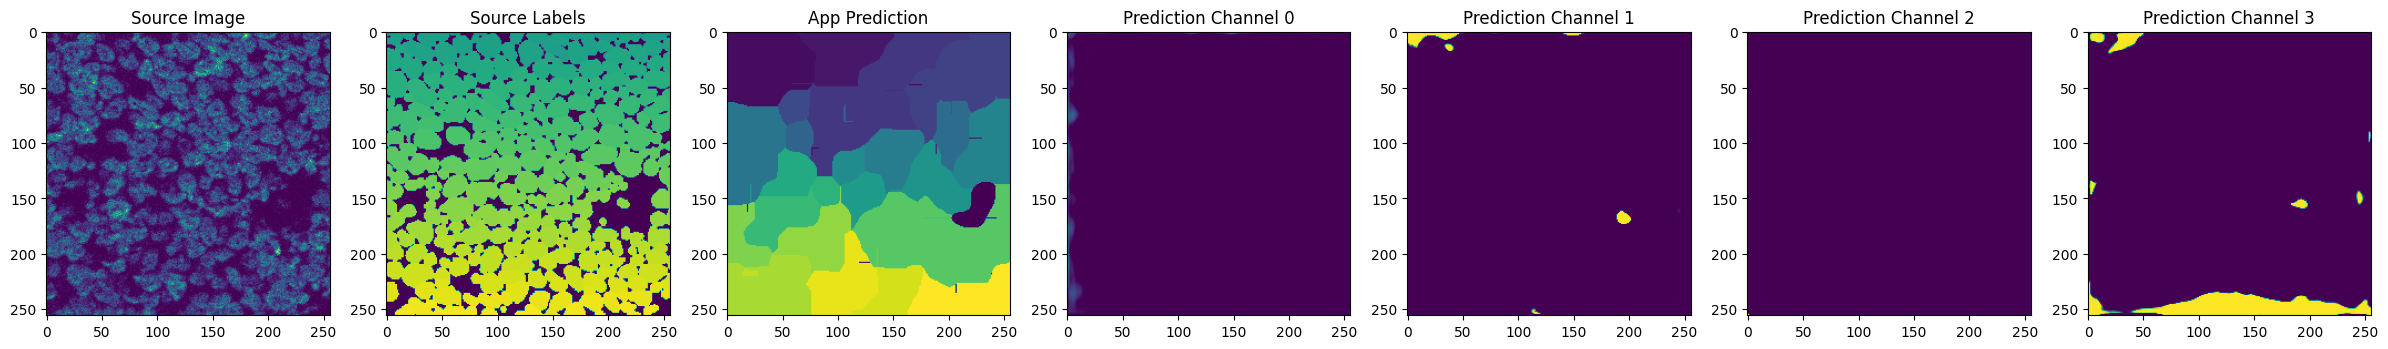

In [48]:
idx = 2
img, lab = X_test[idx].astype(np.float32), y_test[idx]
print(img.shape)

cell_pred = app.predict(np.expand_dims(img, axis=0),)
pred = cpu_model.predict(np.expand_dims(img, axis=0), batch_size=len(img))
fig, axes = plt.subplots(1, 7, figsize=(30, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(lab[ ..., 0])
axes[1].set_title('Source Labels')

axes[2].imshow(cell_pred[0, ...])
axes[2].set_title('App Prediction')

axes[3].imshow(pred[0].cpu().detach().numpy()[0, ..., 0])
axes[3].set_title('Prediction Channel 0')

axes[4].imshow(pred[1].cpu().detach().numpy()[0, ..., 0])
axes[4].set_title('Prediction Channel 1')

axes[5].imshow(pred[2].cpu().detach().numpy()[0, ..., 0])
axes[5].set_title('Prediction Channel 2')

axes[6].imshow(pred[3].cpu().detach().numpy()[0, ..., 2])
axes[6].set_title('Prediction Channel 3')


plt.show()

In [49]:
nuc_preds = app.predict(X_test, compartment="nuclear")
nuc_metrics = evaluate(nuc_preds, y_test[..., 1:])

whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.28it/s]


____________Object-based statistics____________

Number of true cells:		 3056
Number of predicted cells:	 1110

Correct detections:  179	Recall: 0.0586%
Incorrect detections: 931	Precision: 0.1613%


Gained detections: 295	Perc Error 24.0033%
Missed detections: 309	Perc Error 25.1424%
Splits: 0		Perc Error 0.0%
Merges: 557		Perc Error 45.3214%
Catastrophes: 68		Perc Error 5.533%
Gained detectionsfrom split: 0
Missed detectionsfrom merge: 1664
True detectionsin catastrophe: 415
Pred detectionsin catastrophe: 147
SEG: 0.6897 

Average Pixel IOU (Jaccard Index): 0.4687 




/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/metrics.py:1098: UserWarning: Provided data is being relabeled. Cell ids from metrics will not match cell ids in original data. Relabel your data prior to running the metrics package if you wish to maintain cell ids. 
  warnings.warn(


In [35]:
cell_metrics = evaluate(cell_preds, y_test[..., :1])

100%|███████████████████████████████████████████████| 1324/1324 [00:44<00:00, 29.75it/s]
/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/metrics.py:1098: UserWarning: Provided data is being relabeled. Cell ids from metrics will not match cell ids in original data. Relabel your data prior to running the metrics package if you wish to maintain cell ids. 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/metrics.py:280: UserWarning: DICE score is technically 1.0, but prediction and truth arrays are empty.
  warnings.warn('DICE score is technically 1.0, '



____________Object-based statistics____________

Number of true cells:		 145225
Number of predicted cells:	 3940

Correct detections:  290	Recall: 0.002%
Incorrect detections: 3650	Precision: 0.0736%


Gained detections: 321	Perc Error 0.6707%
Missed detections: 44217	Perc Error 92.3844%
Splits: 0		Perc Error 0.0%
Merges: 3199		Perc Error 6.6838%
Catastrophes: 125		Perc Error 0.2612%
Gained detectionsfrom split: 0
Missed detectionsfrom merge: 91592
True detectionsin catastrophe: 6052
Pred detectionsin catastrophe: 255
SEG: 0.6147 

Average Pixel IOU (Jaccard Index): 0.4325 



/tmp/ipykernel_927/35326704.py:10: RuntimeWarning: invalid value encountered in true_divide
  recall = metrics["correct_detections"].values / metrics["n_true"].values


In [51]:
# cell_metrics:
#   catastrophe: 824
#   f1: 0.7834164228098235
#   gained_detections: 15714
#   jaccard: 0.8252
#   merge: 3288
#   missed_detections: 20613
#   n_pred: 138995
#   n_true: 145225
#   precision: 0.8222
#   recall: 0.7869
#   split: 2256

In [52]:
inputs, labels = val_data.next()
cpu_model.eval()
cpu_app = Mesmer(cpu_model)
app_output = cpu_app.predict(inputs)


[print(labels[i].shape) for i in range(len(labels))]

img = inputs[0]
outputs = [i.cpu().detach().numpy() for i in cpu_model.predict(inputs, len(img))]

o_1 = outputs[0]
o_2 = outputs[1]
o_3 = outputs[2]
o_4 = outputs[3]

ch_1 = labels[0]
ch_2 = labels[1]
ch_3 = labels[2]
ch_4 = labels[3]



whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}
(8, 256, 256, 1)
(8, 256, 256, 3)
(8, 256, 256, 1)
(8, 256, 256, 3)


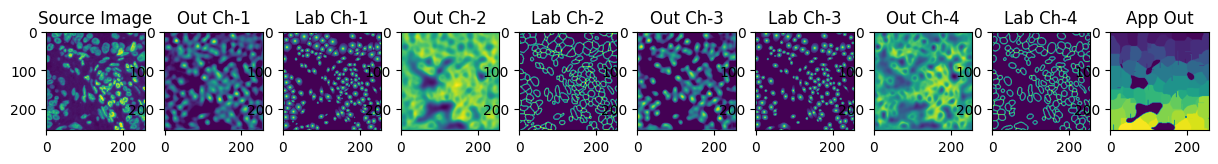

In [53]:
fig, axes = plt.subplots(1, 10, figsize=(15, 15))


axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(o_1[0, ..., 0])
axes[1].set_title('Out Ch-1')

axes[2].imshow(ch_1[0, ..., 0])
axes[2].set_title('Lab Ch-1')

axes[3].imshow(o_2[0, ..., 0])
axes[3].set_title('Out Ch-2')

axes[4].imshow(ch_2[0, ..., 0])
axes[4].set_title('Lab Ch-2')

axes[5].imshow(o_3[0, ..., 0])
axes[5].set_title('Out Ch-3')

axes[6].imshow(ch_3[0, ..., 0])
axes[6].set_title('Lab Ch-3')

axes[7].imshow(o_4[0, ..., 0])
axes[7].set_title('Out Ch-4')


axes[8].imshow(ch_4[0, ..., 0])
axes[8].set_title('Lab Ch-4')

axes[9].imshow(app_output[0, ..., 0])
axes[9].set_title('App Out')

plt.show()


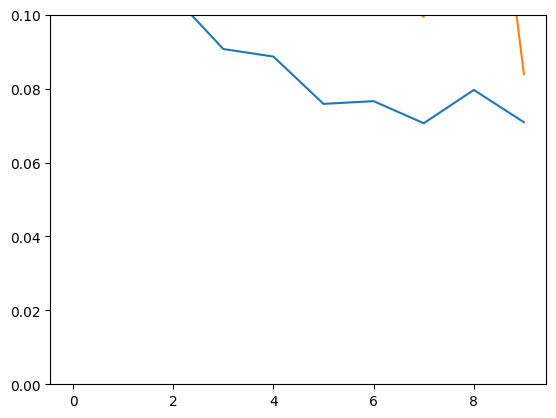

In [54]:
vloss_tracking_cpu = [i.cpu() for i in vloss_tracking]
plt.plot(loss_tracking)
plt.plot(vloss_tracking_cpu)
ax = plt.gca()
ax.set_ylim([0, 0.1])

plt.show()

In [37]:
import pickle
with open("train_loss", "wb") as fp:   #Pickling
    pickle.dump(loss_tracking, fp)
with open("val_loss", "wb") as fp:   #Pickling
    pickle.dump(vloss_tracking, fp)
    